In [1]:
%pylab nbagg
from tvb.simulator.lab import *

Populating the interactive namespace from numpy and matplotlib
   INFO  log level set to INFO


# Tutorial 2: Modeling Epilepsy

The main goal of this tutorial is to provide a clear understanding of how we can reproduce clinically relevant senarios such as the propagation of an epileptic seizure in the human brain, electrical stimulation of a brain region that can trigger a seizure, or surgical resection of brain regions.

## Exploring the Epileptor model

The Epileptor is a phenomenological neural mass model able to reproduce epileptic seizure dynamics such as recorded with intracranial EEG electrodes (see Jirsa_et_al). Before launching any simulations, we will have a look at the phase space of the Epileptor model to better understand its dynamics. We will use the phase plane interactive tool.

<IPython.core.display.Javascript object>


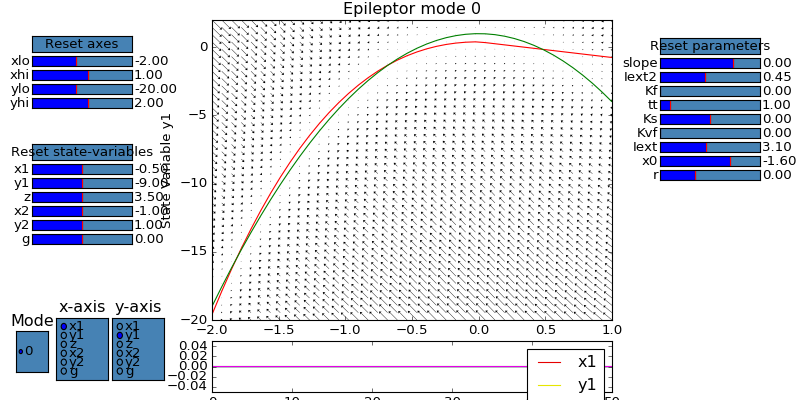

C:\Users\mw\Downloads\TVB_Distribution\tvb_data\Lib\site-packages\matplotlib\cbook.py:137: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive

# Create an Epileptor model instance
epileptor = models.Epileptor()

# Open the phase plane tool with the epileptor model
ppi_fig = PhasePlaneInteractive(model=epileptor)
ppi_fig.show()

Looking at the phase space, we have here the first population (variables $y_0$ in abscissa and
   $y_1$ in ordinate). The left most intersection of the nullcline
   defines a stable fixed point, representing the interictal state, whereas the rightmost intersection is the center of a limit cycle, being the ictal state. Both states are separated by a separatrix, as you can see by drawing different trajectories in this phase space (left click on the figure).


   
   You can also look at other variables in the phase space, such as
   the second population 
   $y_3$ & $y_4$, responsible for hte interical spikes in the Epileptor model. Change the lower and upper bound of the axis to see correctly the phase space.

You can continue to play along to explore the dynamics of this model. For instance, try changing the parameter $x_0$


## Region based simulation of a temporal lobe seizure

We will model a patient with temporal lobe epilepsy (TLE). We
will set different values of epileptogenicity $x_0$ parameter in
the Epileptor according to the region positions, thereby introducing
heterogeneities in the network parameters. We set the right limbic areas
(right hippocampus (rHC, region 47), parahippocampus (rPHC, region 62) and amygdala (rAMYG, region 40))
as epileptic zones. We also add two lesser epileptogenic regions: the superior temporal cortex (rTCI, region 69) and the ventral temporal cortex (rTCV, region 72).

In other words, we assign to all the nodes the *Dynamics* for which $x_0$ has a value of value of $-2.2$. We apply the epileptogenic configuration ($-1.6$) to the right limbic areas. 

Additionally, we chose which kind of coupling we want (between the fast variable (Kvf), the spike-and-wave events (Kf), or the slow permittive coupling (Ks)). Here we use Kf and Ks of them.

Finally, we also slow-down the dynamics of the Epileptor by choosing r=0.00015

In [4]:
epileptors = models.Epileptor(Ks=-0.2, Kf=0.1, r=0.00015)
epileptors.x0 = np.ones((76))*-2.4
epileptors.x0[[62, 47, 40]] = np.ones((3))*-1.6
epileptors.x0[[69, 72]] = np.ones((2))*-1.8

All the other model parameters are the default ones:



|Model parameter|  Value|
|---------------|-------|
| $Iext$        |  3.1  |
| $Iext2$       | 0.45  |
| $slope$       | 0.0   |


Lets load the connectivity matrix and choose the coupling function

In [5]:
con = connectivity.Connectivity(load_default=True)

WARNING  File 'hemispheres' not found in ZIP.


We choose a difference coupling function

In [6]:
coupl = coupling.Difference(a=1.)

We use a stochastic integration scheme; the noise is only added on the two variables of the second population (y3, y4)

In [7]:
hiss = noise.Additive(nsig = numpy.array([0., 0., 0., 0.0003, 0.0003, 0.]))
heunint = integrators.HeunStochastic(dt=0.05, noise=hiss)

We will now set the monitors: a temporal average, an EEG and a SEEG. We need for this to load a region mapping, the projection matrices and the sensors.

In the Epileptor model, the LFP is define as -y0+y3. We want the projection matrices to be applied on the LFP, so we use this as a 'pre' expression. We also keep track of the slow permittivity variable y2.

In [8]:
# load the default region mapping
rm = region_mapping.RegionMapping(load_default=True)

#Initialise some Monitors with period in physical time
mon_tavg = monitors.TemporalAverage(period=1.)
mon_EEG = monitors.EEG(load_default=True,
                       region_mapping=rm,
                       period=1.) 
mon_SEEG = monitors.iEEG(load_default=True,
                         region_mapping=rm,
                         period=1.)

#Bundle them
what_to_watch = (mon_tavg, mon_EEG, mon_SEEG)

Finally, we iniatilise and configure our Simulator object

In [9]:
#Initialise a Simulator -- Model, Connectivity, Integrator, and Monitors.
sim = simulator.Simulator(model=epileptors, connectivity=con,
                          coupling=coupl, 
                          integrator=heunint, monitors=what_to_watch)

sim.configure()


Simulator(bound=False, value=None)

We perform the simulation of 10.000 ms

In [11]:
(ttavg, tavg), (teeg, eeg), (tseeg, seeg) = sim.run(simulation_length=10000)

And we plot the results

C:\Users\mw\Downloads\TVB_Distribution\tvb_data\Lib\site-packages\IPython\kernel\__main__.py:3: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()


<IPython.core.display.Javascript object>


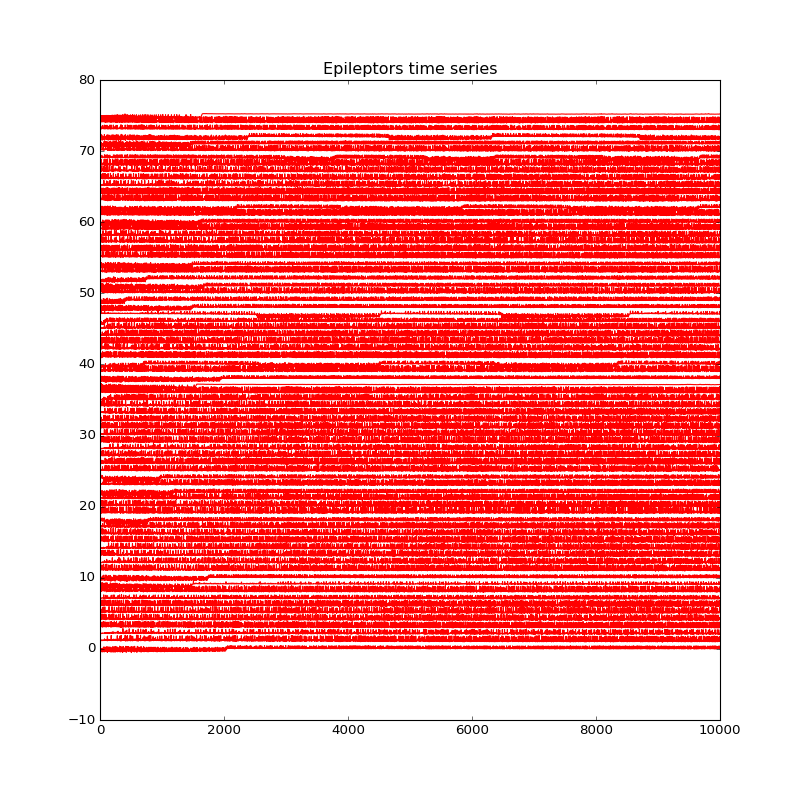

In [12]:
# Normalize the time series to have nice plots
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))
eeg /= (np.max(eeg,0) - np.min(eeg,0 ))
eeg -= np.mean(eeg, 0)
seeg /= (np.max(seeg,0) - np.min(seeg, 0))
seeg -= np.mean(seeg, 0)


#Plot raw time series
figure(figsize=(10,10))
plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:76], 'r')
title("Epileptors time series")
show()

<IPython.core.display.Javascript object>


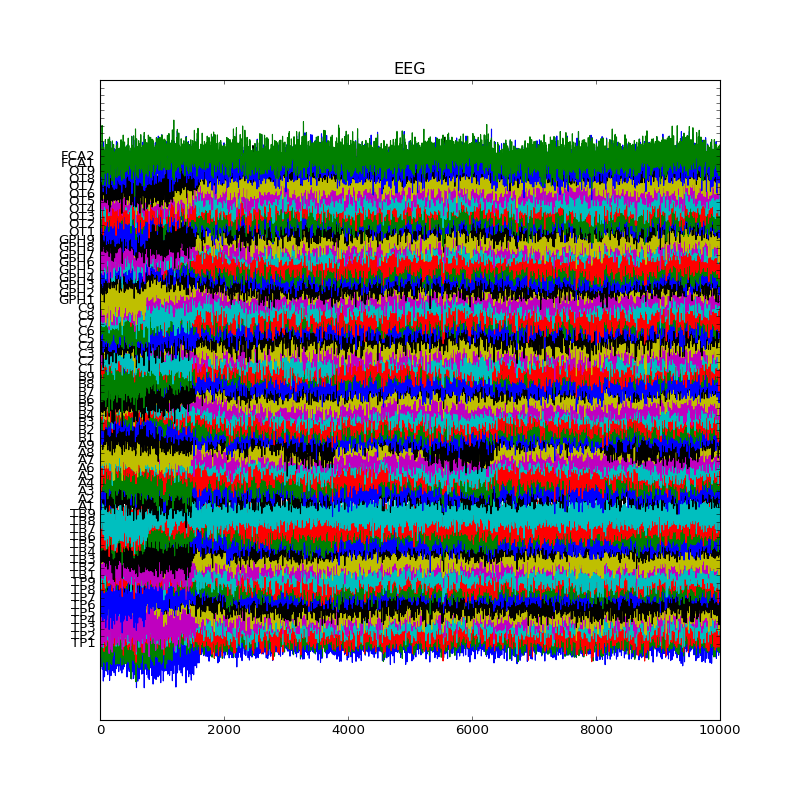

In [13]:
figure(figsize=(10,10))
plot(teeg[:], 10*eeg[:, 0, :, 0] + np.r_[:65])
yticks(np.r_[:75], mon_SEEG.sensors.labels[:65])
title("EEG")

<IPython.core.display.Javascript object>


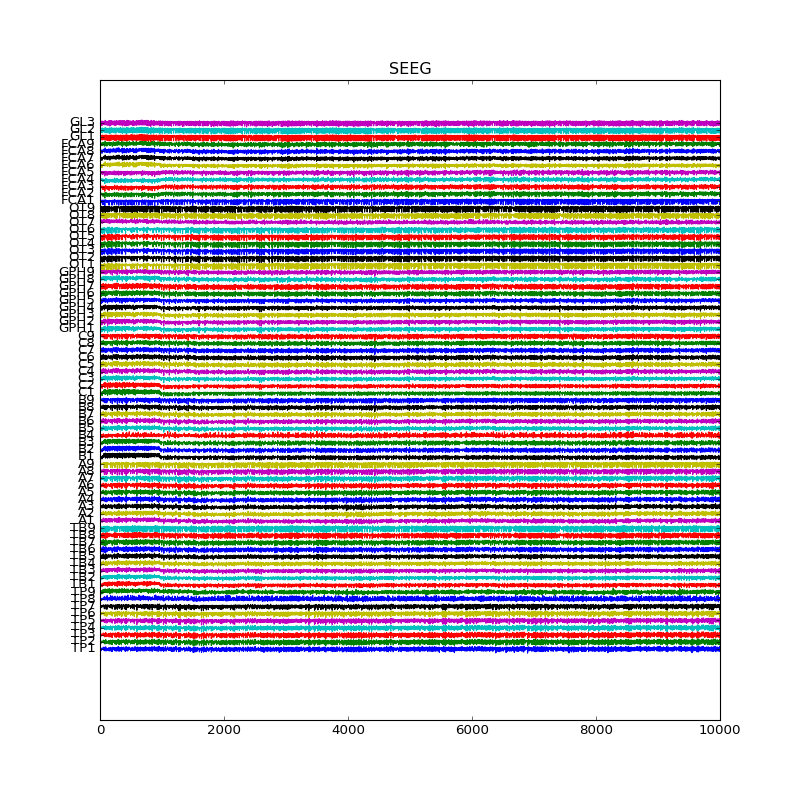

In [14]:
figure(figsize=(10,10))
plot(tseeg[:], seeg[:, 0, :75, 0] + np.r_[:75])
yticks(np.r_[:75], mon_SEEG.sensors.labels[:75])
title("SEEG")

## Modeling surgical resection

Surgical resection is used for around 20% of epileptic patient whose seizures are drug- resistant. We will simulate the hypothetic case of a surgical resection of the amygdala and the hippocampus, but leaving the parahippocampal cortex.

We set all the connections to the right amygdala (40) and right hippocampus (47) to 0 in the connectivity matrix. The resection of the EZ is not complete, will it be enough to prevent seizures?

In [15]:
con = connectivity.Connectivity(load_default=True)
con.weights[[ 47, 40]] = 0.
con.weights[:, [47, 40]] = 0.

WARNING  File 'hemispheres' not found in ZIP.


<IPython.core.display.Javascript object>


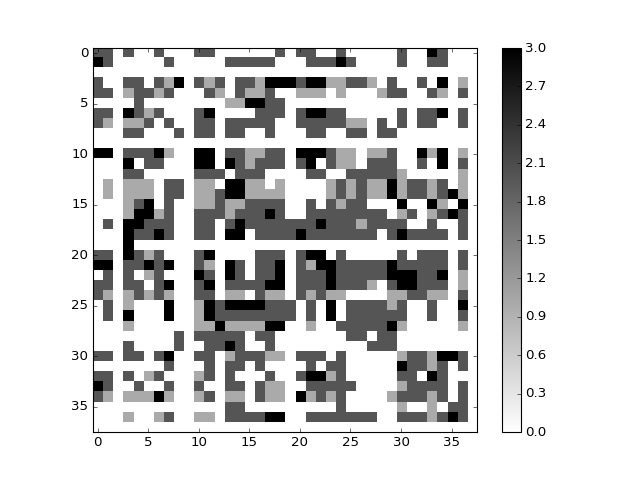

In [16]:
# we plot only the right hemisphere
# the lines and columns set to 0 are clearly visible
figure()
imshow(con.weights[38:, 38:], interpolation='nearest', cmap='binary')
colorbar()
show()

The rest of the model is set as before, but we just use a time average monitor:

In [18]:
coupl = coupling.Difference(a=1.)
hiss = noise.Additive(nsig = numpy.array([0., 0., 0., 0.0003, 0.0003, 0.]))
heunint = integrators.HeunStochastic(dt=0.05, noise=hiss)
mon_tavg = monitors.TemporalAverage(period=1.)

We can now relaunch our first simulation, taking care of replacing the dynamic of the EZ by a stable node, as if the region was resected.

In [19]:
epileptors = models.Epileptor(Ks=-0.2, Kf=0.1, r=0.00015)
epileptors.x0 = np.ones((76))*-2.4
epileptors.x0[[69, 72]] = np.ones((2))*-1.8
sim = simulator.Simulator(model=epileptors, connectivity=con,
                          coupling=coupl, 
                          integrator=heunint, monitors=mon_tavg)

sim.configure();

In [20]:
(ttavg, tavg), = sim.run(simulation_length=10000)

As you can see, no seizure is triggered anymore

<IPython.core.display.Javascript object>


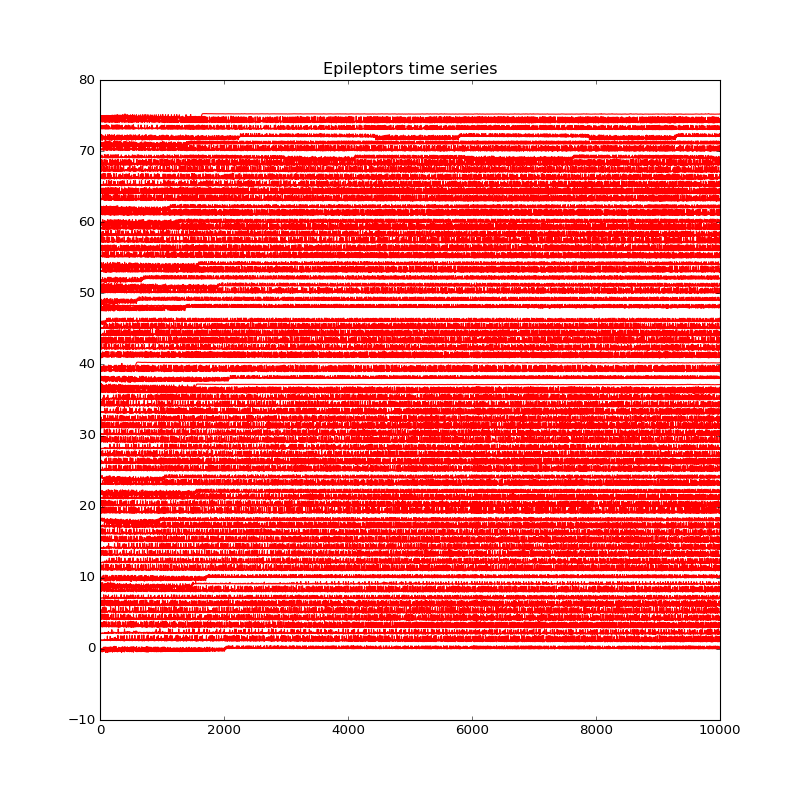

In [21]:
# normalize the time series
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))

figure(figsize=(10,10))
plot(ttavg[:], tavg[:, 0, :, 0] + np.r_[:76], 'r')
title("Epileptors time series")
show()

## Triggering a seizure by stimulation

We are now going to model an electric stimulation and trigger a seizure. We set the whole brain to non-epileptogenic but close to the threshold

In [22]:
epileptors = models.Epileptor(Ks=-0.2, Kf=0.1, r=0.00035)
epileptors.x0 = np.ones((76))*-2.1
con = connectivity.Connectivity(load_default=True)
coupl = coupling.Difference(a=0.)
heunint = integrators.HeunDeterministic(dt=0.05)
mon_tavg = monitors.TemporalAverage(period=1.)

WARNING  File 'hemispheres' not found in ZIP.


In [23]:
# Weighting for regions to receive stimuli.
weighting = numpy.zeros((76))
weighting[[69, 72]] = numpy.array([2.])

In [24]:
eqn_t = equations.PulseTrain()
eqn_t.parameters["T"] = 10000.0
eqn_t.parameters["onset"] = 2500.0
eqn_t.parameters["tau"] = 50.0
eqn_t.parameters["amp"] = 20.0
stimulus = patterns.StimuliRegion(temporal = eqn_t,
                                  connectivity = con, 
                                  weight = weighting)

<IPython.core.display.Javascript object>


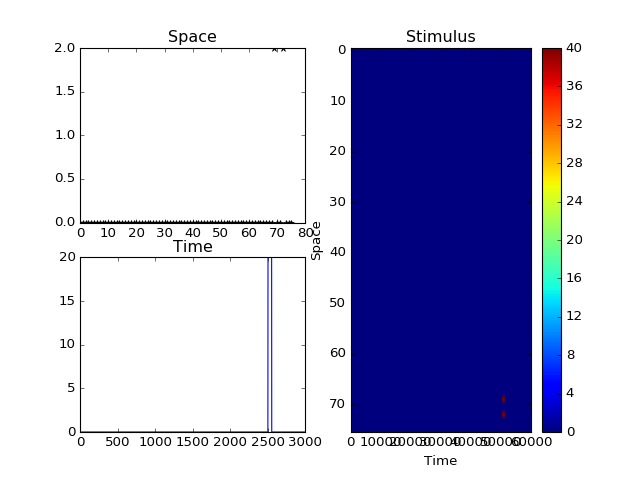

In [25]:
#Configure space and time
stimulus.configure_space()
stimulus.configure_time(numpy.arange(0., 3000., heunint.dt))

#And take a look
plot_pattern(stimulus)
show()


In [26]:
#Bundle them
what_to_watch = (mon_tavg, )
#Initialise Simulator -- Model, Connectivity, Integrator, Monitors, and stimulus.
sim = simulator.Simulator(model=epileptors, connectivity=con,
                          coupling=coupl, 
                          integrator=heunint, monitors=what_to_watch, 
                          stimulus=stimulus)

sim.configure()


Simulator(bound=False, value=None)

In [27]:
(t, tavg), = sim.run(simulation_length=10000)

<IPython.core.display.Javascript object>


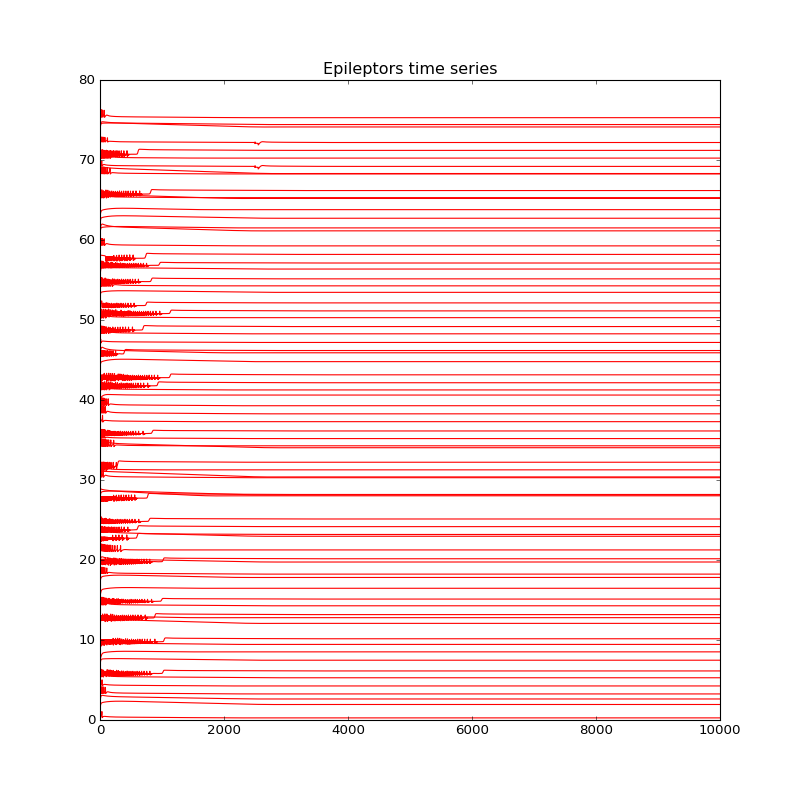

In [28]:
# Normalize the time series to have nice plots
tavg /= (np.max(tavg,0) - np.min(tavg,0 ))

#Plot raw time series
figure(figsize=(10,10))
plot(t[:], tavg[:, 0, :, 0] + np.r_[:76], 'r')
title("Epileptors time series")

#Show them
show()